In [1]:
import torch

data = torch.load("../Test_dict.pt")

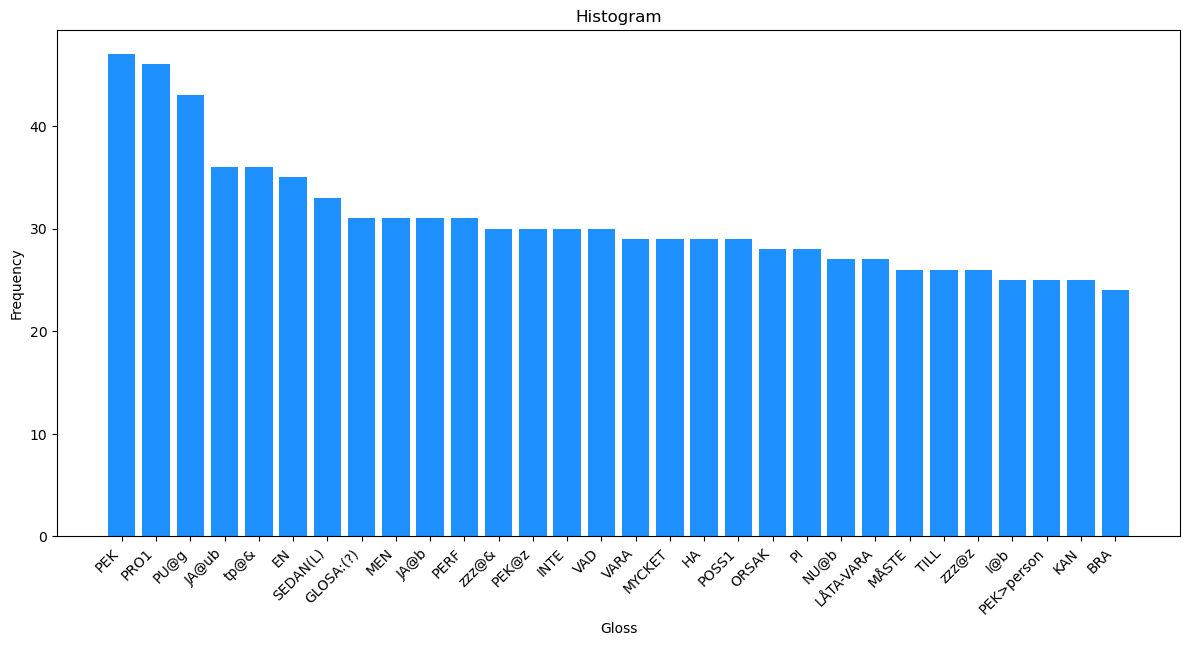

In [4]:
from analytics import display_histogram

display_histogram(data, 30, True)

In [1]:
import torch
# Load data
data = torch.load("../Test_dict.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Small subset
# data = {
#     "features": data["features"][2:4],  # 10 examples
#     "gloss": data["gloss"][2:4]
# }

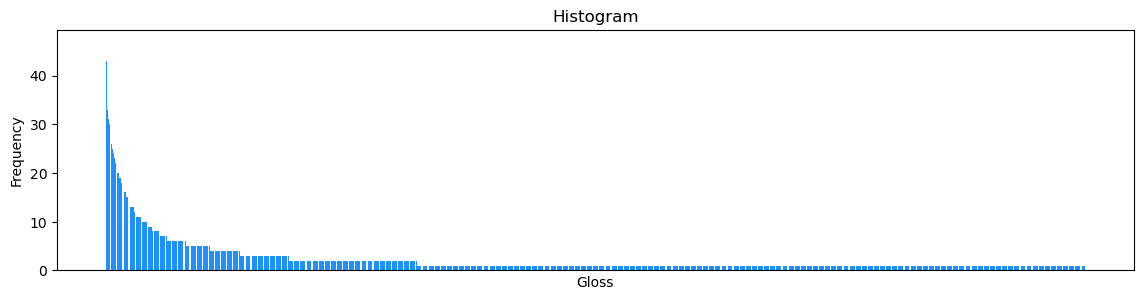

In [3]:
from pipeline import TransformerPipeline
pipeline = TransformerPipeline(device, 'base-transformer')
train_loader, val_loader, test_loader = pipeline.process_data(
    data = data, 
    batch_size = 4,
    chunk_size = 128,
    stride = None,
    alignment = True,
    shuffle = True,
    train_ratio = 0.8,
    val_ratio = 0.1,
)
pipeline.vocabulary.display_histogram(pipeline.vocabulary.size, tick=False)

In [ ]:
from pipeline import TransformerPipeline
from models import BaseTransformer, CTCTransformer
# Initialize pipeline
pipeline = TransformerPipeline(device, 'base-transformer')
# pipeline = TransformerPipeline(device, 'ctc-transformer')

# Create loaders
train_loader, val_loader, test_loader = pipeline.process_data(
    data = data, 
    batch_size = 4,
    chunk_size = 128,
    stride = None,
    alignment = True,
    shuffle = True,
    train_ratio = 0.8,
    val_ratio = 0.1,
)

# Initialize model
model = BaseTransformer(
    input_dim = data["features"][0].shape[1],
    vocab_size = pipeline.vocabulary.size,
    d_model = 256,
    nhead = 4,
    num_layers = 2,
    dim_feedforward = 512,
    dropout = 0,
    max_len = 5000,
    use_cnn = True,
).to(device)

# model = CTCTransformer(
#     input_dim = data["features"][0].shape[1],
#     vocab_size = pipeline.vocabulary.size,
#     d_model = 256,
#     nhead = 4,
#     num_layers = 4,
#     dim_feedforward = 512,
#     dropout = 0,
#     max_len = 5000,
#     use_cnn = True,
# ).to(device)

# Train model
metrics = pipeline.train_model(
    model = model, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    epochs = 200, 
    early_stop = None,
    lr = 1e-4,
)


Epoch 200/200: 100%|██████████| 6/6 [00:00<00:00,  7.35it/s, Loss=0.0026]


Test WER: 0.01
[] 0
[] 0


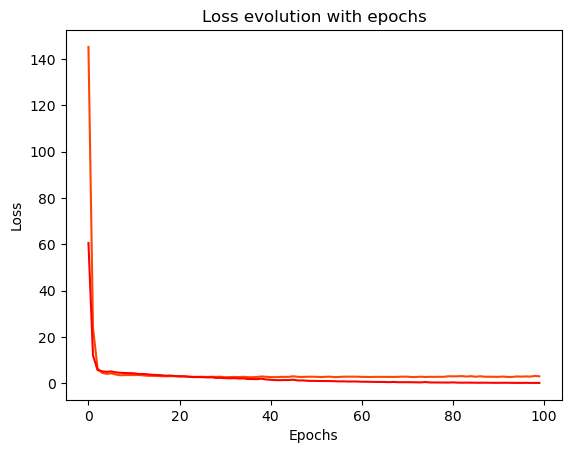

128


c:\Users\noedo\Desktop\ETUDES\INP\2A\S2\Speech and Speaker Recognition\Project\DT2119_project\analytics.py:28: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


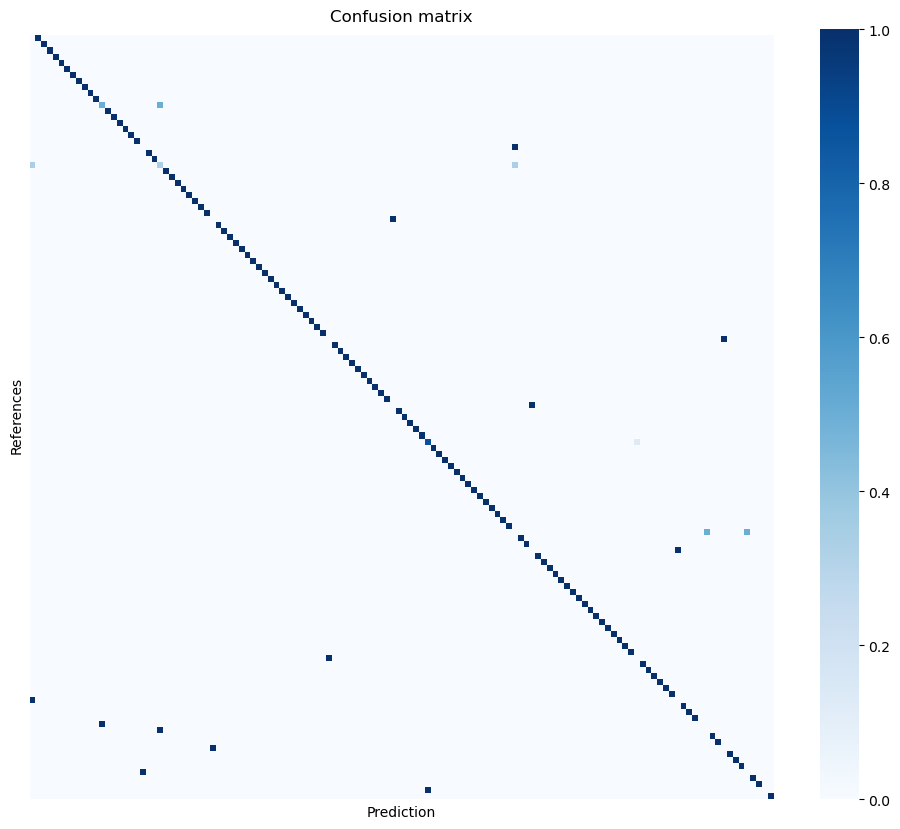

In [67]:
from analytics import display_confusion_matrix, display_metrics

wer_score, pred_sequences, ref_sequences = pipeline.test_model(model, train_loader)
i=0
print(pred_sequences[i], len(pred_sequences[i]))
print(ref_sequences[i],len(ref_sequences[i]))

display_metrics(metrics)
display_confusion_matrix(pred_sequences, ref_sequences)

In [48]:
for i in range(len(pred_sequences)):
    print('pred', i, len(pred_sequences[i]), pred_sequences[i])
    # print('ref', i, len(ref_sequences[i]), ref_sequences[i])

pred 0 0 []
pred 1 1 ['PEK']
pred 2 6 ['PEK', 'ONÖDAN', 'PRO1', 'TAND^KRÄM', 'GLÖMMA', 'ENTITET(4)+BEFINNA@p.FL']
pred 3 4 ['PEK-PLATS-HÄR', 'SEDAN(L)', 'VAD', 'MER']
pred 4 0 []
pred 5 5 ['FÖRÄLDRAR(L)', 'tp@&', 'PACKA-UPP', 'BURK(S)', 'KASTA']


In [68]:
for pred, ref in zip(pred_sequences, ref_sequences):
    if len(ref) != 0:
        print('ref:', len(ref), ref)
        print('pred:', len(pred), pred)

ref: 9 ['SAK.PL', 'TOALETT(L)^VÄSKA', 'GREPP(JJv)+HANTERA@p', 'TVÅL', 'TA@z', 'KALSONG', 'TA@z', 'GREPP(AA)+HANTERA@p@z', 'TAND^KRÄM']
pred: 9 ['SAK.PL', 'TOALETT(L)^VÄSKA', 'GREPP(JJv)+HANTERA@p', 'TVÅL', 'TA@z', 'KALSONG', 'TA@z', 'GREPP(AA)+HANTERA@p@z', 'TAND^KRÄM']
ref: 4 ['ENTITET(4)+BEFINNA@p.FL', 'SÅ-ATT-SÄGA', 'PU@g', 'JA@ub']
pred: 4 ['ENTITET(4)+BEFINNA@p.FL', 'SÅ-ATT-SÄGA', 'PU@g', 'JA@ub']
ref: 15 ['BESTÄMMA-SIG', 'BYGGA(J)', 'polysynt@&', 'LÅTA-SÄGA', 'Ö', 'BOJ-AVGRÄNS(da)', 'boj-avgräns(da)@hd@nh', 'BYGGA(J)', 'ENTITET(4)+BEFINNA@p.FL', 'SITTA(VVb)', 'sitta(vb)@hd', 'EGEN', 'SITTA(VVb)', 'glosa@&', 'ENTITET(4)+BEFINNA@p.FL']
pred: 14 ['BESTÄMMA-SIG', 'BYGGA(J)', 'polysynt@&', 'LÅTA-SÄGA', 'Ö', 'BOJ-AVGRÄNS(da)', 'BYGGA(J)', 'ENTITET(4)+BEFINNA@p.FL', 'SITTA(VVb)', 'sitta(vb)@hd', 'EGEN', 'SITTA(VVb)', 'glosa@&', 'ENTITET(4)+BEFINNA@p.FL']
ref: 13 ['TA', 'EN', 'STÖRRE', 'RESA^VÄSKA', 'GREPP(GJ)+HANTERA@p', 'BOK', 'ENTITET(J)+FÖRFLYTTA@p', 'MINDRE(J)', 'RESA^VÄSKA', 'GREPP

In [15]:
# Testing model

from jiwer import wer

def remove_consecutive_duplicates(seq):
    if not seq:
        return []
    cleaned = [seq[0]]
    for token in seq[1:]:
        if token != cleaned[-1]:
            cleaned.append(token)
    return cleaned


def test_model1(model, test_loader):
    model.eval()
    pred_sequences = []
    ref_sequences = []
    wer_sequence = []

    blank = pipeline.vocabulary.blank_token
    start_token = pipeline.vocabulary.start_token
    end_token = pipeline.vocabulary.end_token

    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(pipeline.device)
            src_key_padding_mask = batch['src_key_padding_mask'].to(pipeline.device)

            if pipeline.model_type == 'ctc-transformer':
                targets = batch['targets']
                target_lengths = batch['target_lengths']

                logits = model(features, src_key_padding_mask=src_key_padding_mask)
                log_probs = F.log_softmax(logits, dim=-1)
                preds = log_probs.argmax(dim=-1).cpu()

                # slice & decode
                start_idx = 0
                for i, length in enumerate(target_lengths):
                    target_seq = targets[start_idx : start_idx + length].tolist()
                    start_idx += length

                    pred_seq = preds[i].tolist()
                    decoded = []
                    prev_token = None
                    for token in pred_seq:
                        if token != blank and token != prev_token:
                            decoded.append(token)
                        prev_token = token

                    pred_str = [pipeline.vocabulary.int2str.get(idx, "<unk>") for idx in decoded]
                    ref_str = [pipeline.vocabulary.int2str.get(idx, "<unk>") for idx in target_seq if idx != blank]

                    pred_sequences.append(pred_str)
                    ref_sequences.append(ref_str)

                    wer_value = wer(" ".join(ref_str), " ".join(pred_str)) if pred_str else 1.0
                    wer_sequence.append(wer_value)

            else:  # base-transformer
                targets = batch['decoder_targets']
                pred_ids = model.predict(features, start_token=start_token, end_token=end_token,
                                        src_key_padding_mask=src_key_padding_mask)

                for i, pred_seq in enumerate(pred_ids):
                    target_seq = targets[i, :].tolist()  # skip <sos>
                    if end_token in target_seq:
                        target_seq = target_seq[:target_seq.index(end_token)]

                    pred_str = [pipeline.vocabulary.int2str.get(idx, "<unk>") for idx in pred_seq if idx not in (start_token, end_token, pipeline.vocabulary.pad_token)]
                    ref_str = [pipeline.vocabulary.int2str.get(idx, "<unk>") for idx in target_seq if idx not in (start_token, end_token, pipeline.vocabulary.pad_token)]
                    
                    pred_str = remove_consecutive_duplicates(pred_str)
                    ref_str = remove_consecutive_duplicates(ref_str)
                    
                    pred_sequences.append(pred_str)
                    ref_sequences.append(ref_str)

                    wer_value = wer(" ".join(ref_str), " ".join(pred_str)) if (pred_str and ref_str)  else 1.0
                    wer_sequence.append(wer_value)

    mean_wer = sum(wer_sequence) / len(wer_sequence) if wer_sequence else float('inf')
    print(f"Test WER: {mean_wer:.2f}")

    return mean_wer, pred_sequences, ref_sequences

Test WER: 0.78
18 ['BRIDGE', 'FÖRUT', 'SEDAN(L)', 'KVÄLL', 'FEST', 'fest@hd', 'PRO1', 'PERF-NEG', 'DEL', 'PRO1', 'RÄDD', 'rädd@hd', 'RÄDD', 'MÖRK', 'UTE', 'GLOSA:VINGLA@rd', 'OCH@z', 'KAN']
18 ['BRIDGE', 'FÖRUT', 'SEDAN(L)', 'KVÄLL', 'FEST', 'fest@hd', 'PRO1', 'PERF-NEG', 'DEL', 'PRO1', 'RÄDD', 'rädd@hd', 'RÄDD', 'MÖRK', 'UTE', 'GLOSA:VINGLA@rd', 'OCH@z', 'KAN']
11 ['TAXI(8b)', 'KAN', 'mtyp:men', 'PU@g', 'PRO1', 'MYCKET', 'FÖR', 'FEST', 'NU@b', 'mtyp:nä', 'JA@ub']
11 ['TAXI(8b)', 'KAN', 'mtyp:men', 'PU@g', 'PRO1', 'MYCKET', 'FÖR', 'FEST', 'NU@b', 'mtyp:nä', 'JA@ub']
22 ['KOMPIS.PL', 'PEK.FL', 'KAMRAT', 'PU-ETCETERA@g', 'SJÄLVKLAR', 'PRO1', 'KOMMA-DIT(Lb)', 'ROLIG', 'PU-ETCETERA@g', 'SJÄLVKLAR', 'mtyp:men', 'I@b^DAG', 'INTE', 'SAMMA', 'SAK', 'PÅKALLA-UPPMÄRKSAMHET@g>person', 'SIST', 'tp@&', 'FEST', 'tp@&', 'PEK>person/PEK', 'BBM@b@en']
40 ['KOMPIS.PL', 'PEK.FL', 'KAMRAT', 'PU-ETCETERA@g', 'SJÄLVKLAR', 'PRO1', 'KOMMA-DIT(Lb)', 'ROLIG', 'PU-ETCETERA@g', 'SJÄLVKLAR', 'mtyp:men', 'I@b^DAG',

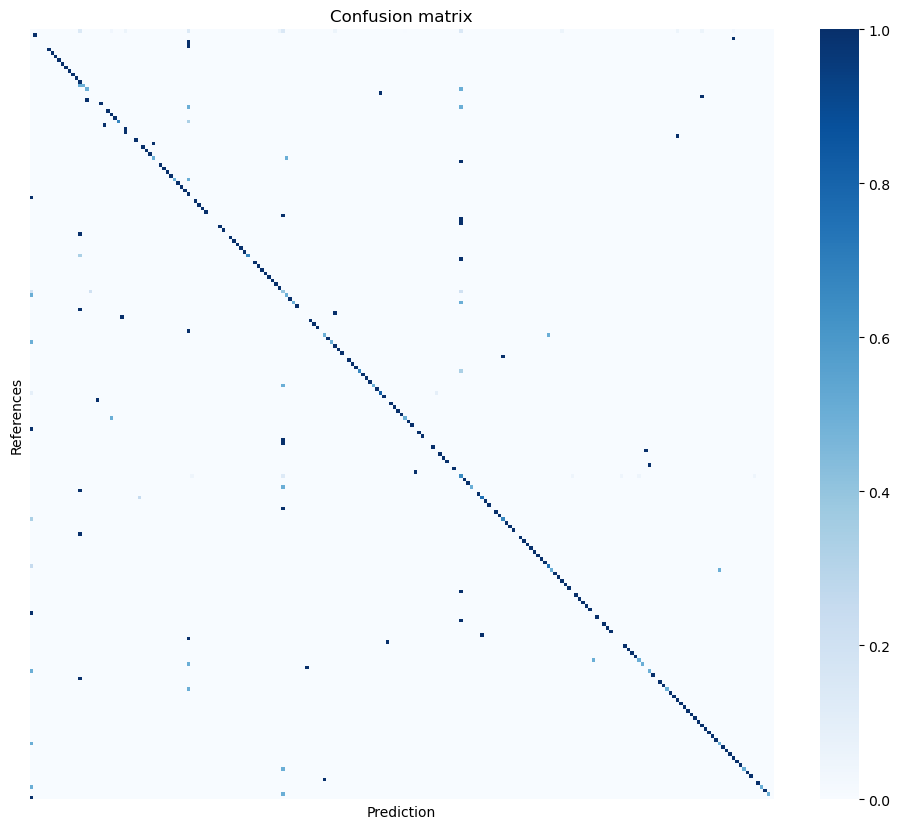

In [16]:
wer_score, pred_sequences, ref_sequences = test_model1(model, train_loader)
for pred, ref in zip(pred_sequences, ref_sequences):
    if len(ref) != 0:
        print(len(ref), ref)
        print(len(pred), pred)

# display_metrics(metrics)
display_confusion_matrix(pred_sequences, ref_sequences)